<a href="https://colab.research.google.com/github/rja868/financial-forecasting/blob/main/financial_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Forecasting
Richard Albanese

## Imports and Data Exploration

In [1]:
! pip install pmdarima  #install the pmdarima library
! pip install yfinance  # Install yfinance package

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.4 MB/s eta 0:00:00


In [2]:
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns


[*********************100%***********************]  1 of 1 completed


-------Raw Data-------
Price      Adj Close Close  High   Low  Open  Volume
Ticker           GTX   GTX   GTX   GTX   GTX     GTX
Date                                                
2022-01-03      7.85  7.85  8.23  7.81  8.10  211600
2022-01-04      7.85  7.85  8.03  7.79  7.79  556400
2022-01-05      7.99  7.99  8.12  7.81  7.88  386600
2022-01-06      8.02  8.02  8.10  7.80  8.05  178700
2022-01-07      7.89  7.89  8.04  7.83  7.96  156300

-------Engineered Data (stock_data)-------
Price    Adj Close       Close        High         Low        Open  \
Ticker         GTX         GTX         GTX         GTX         GTX   
count   764.000000  764.000000  764.000000  764.000000  764.000000   
mean      7.823279    7.823279    7.961323    7.695077    7.821544   
std       0.936374    0.936374    0.930507    0.935103    0.937238   
min       5.570000    5.570000    5.760000    5.570000    5.580000   
25%       7.280000    7.280000    7.400000    7.128750    7.257500   
50%       7.740000 

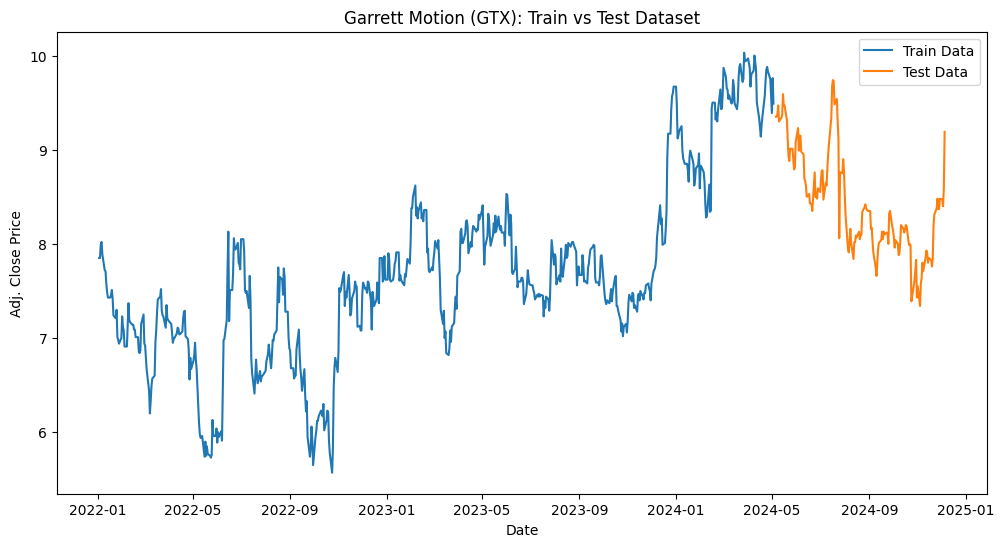

In [3]:
# Data Acquisition
stock_data = yf.download('GTX', start='2022-01-01', end='2024-12-06')  # Changed end date to Friday 12/6/24
stock_data.sort_index(ascending=True, inplace=True)

# Ensure proper DatetimeIndex with frequency for time series analysis
stock_data.index = pd.to_datetime(stock_data.index)

# asfreq method changes the frequency of the time series index, 'B' is business day frequency (M-F only).  Holidays that land on business days with missing data are added as new rows with NaN values.
# ffill forward-fills missing values created by the reindexing using the last available value (the previous trading day's closing price)
stock_data = stock_data.asfreq('B', method='ffill')

print('-------Raw Data-------')
print(stock_data.head())

# Calculate rolling averages
stock_data['7_day_avg'] = stock_data['Adj Close'].rolling(window=7, min_periods=1).mean()  # 7-day rolling average using "Adj Close" to reflect stock splits and dividend payments
stock_data['30_day_avg'] = stock_data['Adj Close'].rolling(window=30, min_periods=1).mean()  # 30-day rolling average

print('\n-------Engineered Data (stock_data)-------')
print(stock_data.describe())

# Determine new date to split the data because I expanded the dataset with a more recent end date above
new_split_date = stock_data.index[610]  # Row 610 is 80% of the dataset

# Split the data into training and test sets
split_date = pd.to_datetime(new_split_date)
train = stock_data.loc[stock_data.index < split_date]
test = stock_data.loc[stock_data.index >= split_date]

# Prepare the training and test data for Linear Regression
X_train = train[['7_day_avg', '30_day_avg']]  # X_train will only contain the newly created 7 day and 30 day rolling average data points (not the actual stock prices)
y_train = train['Adj Close']  # y_train contains the adjusted closing prices pulled from the training data
X_test = test[['7_day_avg', '30_day_avg']]  #  For the test data, the model will only look at the 7 day and 30 day rolling averages (not the actual stock prices)

# Visualization of Train and Test Datasets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Adj Close'], label='Train Data')
plt.plot(test.index, test['Adj Close'], label='Test Data')
plt.title('Garrett Motion (GTX): Train vs Test Dataset')
plt.xlabel('Date')
plt.ylabel('Adj. Close Price')
plt.legend()
plt.show()

## Model Building

**Implement linear regression using 7 and 30 day rolling averages**

In [4]:
# Initialize and train the linear regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

LinearRegression()

In [5]:
# Use the linear regression model to make predictions on the test data
y_pred_linear_reg = linear_reg_model.predict(X_test)

**Create an Exponential Smoothing model that accounts for trend and seasonality (Holt-Winters Exponential Smoothing)**



In [6]:
# Import required library
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [7]:
# Fit the Holt-Winters model
hw_model = ExponentialSmoothing(train['Adj Close'],
                              trend='add',  # Additive trend
                              seasonal='add',  # Additive seasonality
                              seasonal_periods=7)  # Weekly seasonality (7 days)

fit = hw_model.fit()

In [8]:
# Use the Holt-Winters model to make predictions on the test data
y_pred_hw = fit.forecast(len(test))

## Performance Metrics

**Calculate MAE, MSE and RMSE for each model / Provide commentary on the performance of each model**


In [9]:
# Calculate performance metrics for linear regression model
mae_linear_reg = mean_absolute_error(test['Adj Close'], y_pred_linear_reg)
mse_linear_reg = mean_squared_error(test['Adj Close'], y_pred_linear_reg)
rmse_linear_reg = np.sqrt(mse_linear_reg)

# Print performance metrics
print("------Linear Regression Model Performance Metrics------")
print(f"Mean Absolute Error (MAE): {mae_linear_reg:.2f}")
print(f"Mean Squared Error (MSE): {mse_linear_reg:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_linear_reg:.2f}")

------Linear Regression Model Performance Metrics------
Mean Absolute Error (MAE): 0.17
Mean Squared Error (MSE): 0.05
Root Mean Squared Error (RMSE): 0.23


The target variable is the adjusted closing price for GTX shares.  For our linear regression model, a MAE of 0.17, tells us the model's prediction of the adjusted closing price are off by an average of $0.17.

Unlike MAE, MSE penalizes larger errors more severely because the errors are squared.  Importantly, this metric is expressed in dollars *squared*, which is less interpretable than MAE which is being expressed is dollars (not squared).

RMSE is in the same unit as MAE ($, not squared), which makes it easier to interpret.  But like MSE, it's sensitive to outliers and penalizes large errors.

The relative importance of these error measurements would be dependent on the trading/investing strategy we are seeking to implement.  


In [10]:
# Calculate performance metrics for Holt-Winters model
mae_hw = mean_absolute_error(test['Adj Close'], y_pred_hw)
mse_hw = mean_squared_error(test['Adj Close'], y_pred_hw)
rmse_hw = np.sqrt(mse_hw)

# Print performance metrics
print("------Holt-Winters Model Performance Metrics------")
print(f"Mean Absolute Error (MAE): {mae_hw:.2f}")
print(f"Mean Squared Error (MSE): {mse_hw:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_hw:.2f}")

------Holt-Winters Model Performance Metrics------
Mean Absolute Error (MAE): 1.30
Mean Squared Error (MSE): 2.09
Root Mean Squared Error (RMSE): 1.45


Based on the above metrics, the Holt-Winters model clearly underperforms the linear regression model with an MAE of 1.30 (vs. 0.17 for the linear reg), MSE of 2.09 (vs. 0.05 for linear reg) and RMSE of 1.45 (vs. 0.23 for the linear reg).

There are a few reasons why the Holt-Winters model underperformed:
1.   Patterns of trend and seasonality may be very limited in our GTX share price data. Holt-Winters may be overfitting the historical data by attempting to identify trend and seasonality components that don't exist to the degree that they are predictive of future prices.
2.   Stock prices are effected by company-specific news, economic factors and other events which can lead to immediate changes in share price and volatility.  For example, a large mutual fund may, all of a sudden, start buying shares of GTX because they recently hired a new investment team that has a favorable view of these types of companies.  If this firm had never previously purchased GTX shares, it is unlikely the buying patterns of the new investment team would be reflected in past share prices unless the investment professionals were buying GTX shares at their previous firm(s).  Unexpected government legislation and geopolitical events are other examples of events that can greatly impact share prices. The Holt-Winters model will not adapt to the price impact of these factors (unless the factors occur with regularity or seasonality, which they rarely do).  
3.  Stock prices are often considered random in nature with future prices independent of past prices.  Holt-Winters assumes future prices can be inferred from historical patterns so the effect of randomness is likely degrading performance.  Yet, the price trend itself does appear to have some predictive value based on the superior performance of our linear regression model.
4.  The linear regression model is using two features (7 and 30 day SMA), while the Holt-Winters model is only using a single feature (adjusted closing price).  This may partially explain the linear regression model's superior performance.




## Model Comparison and Interpretation

**Visualize model performance by plotting the forecasted values against the actual values.**

In [11]:
print(y_pred_linear_reg.shape)


(154, 1)


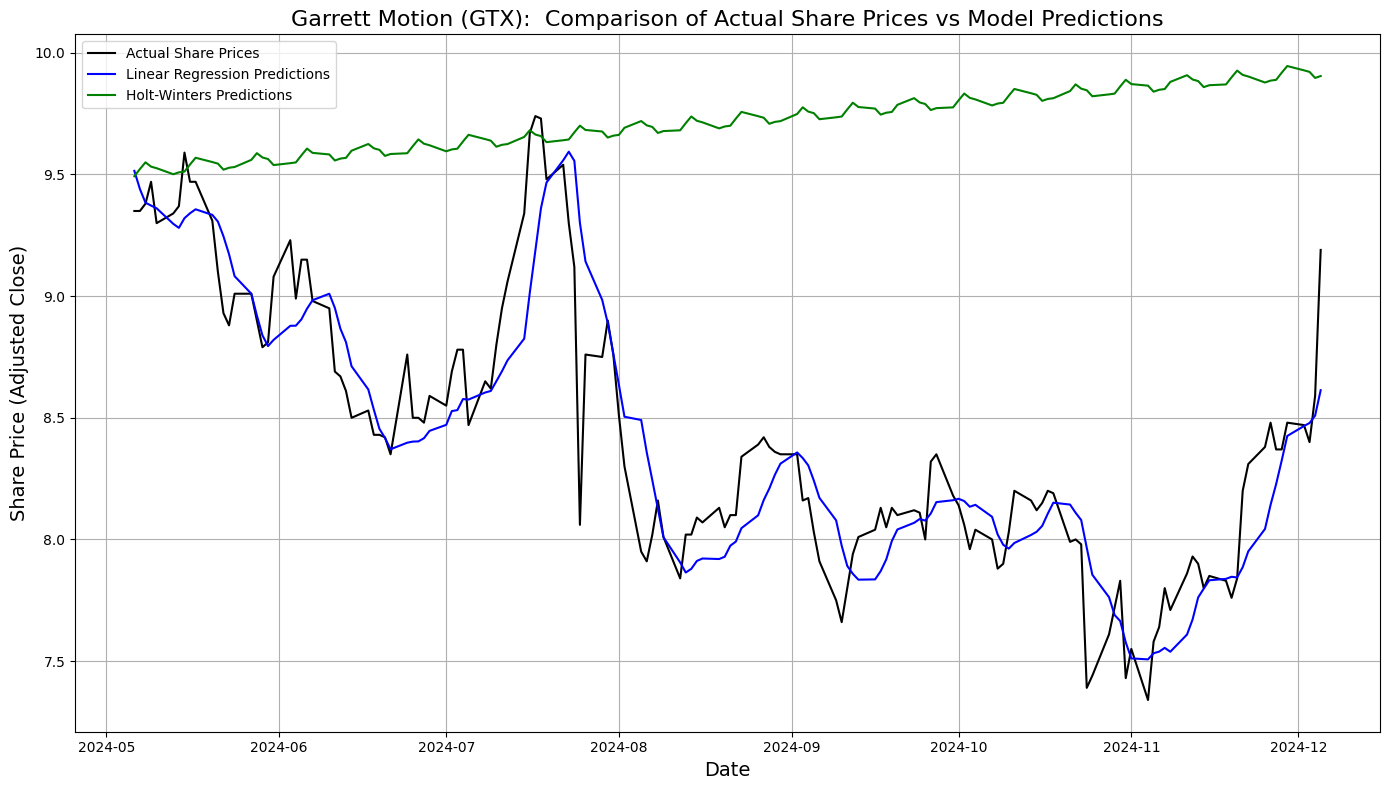

In [12]:
plt.figure(figsize=(14, 8))
plt.plot(test.index, test['Adj Close'], label="Actual Share Prices", color="black") # Plot actual share prices in test data
plt.plot(test.index, y_pred_linear_reg, label="Linear Regression Predictions", color="blue") # Plot Linear Regression predictions
plt.plot(test.index, y_pred_hw, label="Holt-Winters Predictions", color="green") # Plot Holt-Winters predictions

plt.title("Garrett Motion (GTX):  Comparison of Actual Share Prices vs Model Predictions", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Share Price (Adjusted Close)", fontsize=14)
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

**Interpretation and discussion of model results/performance**

The plot clearly shows the linear regression model is more effective at forecasting future share prices.  The linear regression model is using a 7 and 30 day SMA as inputs.  This combination articulates the short and medium term trend of the share price.  Using these two moving averages allows the model to take into account short-term volatility and medium-term stability in the overall trend.

Looking at areas of improvement, the prices predicted by the linear regression model appear to lag the actual share prices at times.  In other words, the actual price seems to reach certain price levels before the model predicts the price reaching that level.  Let's take a closer look at July 2024 in order to better understand the issue:

In [13]:
y_pred_lr = y_pred_linear_reg[:,0]
adj_close_actual = test['Adj Close'].squeeze()

comparison_df = pd.DataFrame({
    'Date': test.index,
    'Actual': adj_close_actual,
    'LR Prediction': y_pred_lr,
})

In [14]:
comparison = comparison_df.drop(columns=['Date'])

In [15]:
july_2024_df = comparison.loc['2024-07-01':'2024-07-30']

Table comparing Actual and LR Prediction prices in July 2024:

In [16]:
july_2024_df.head(30)

,Actual,LR Prediction
Date,,
2024-07-01,8.55,8.471011
2024-07-02,8.69,8.527597
2024-07-03,8.78,8.531574
2024-07-04,8.78,8.576951
2024-07-05,8.47,8.574925
2024-07-08,8.65,8.604016
2024-07-09,8.62,8.610265
2024-07-10,8.80,8.650268
2024-07-11,8.95,8.691205


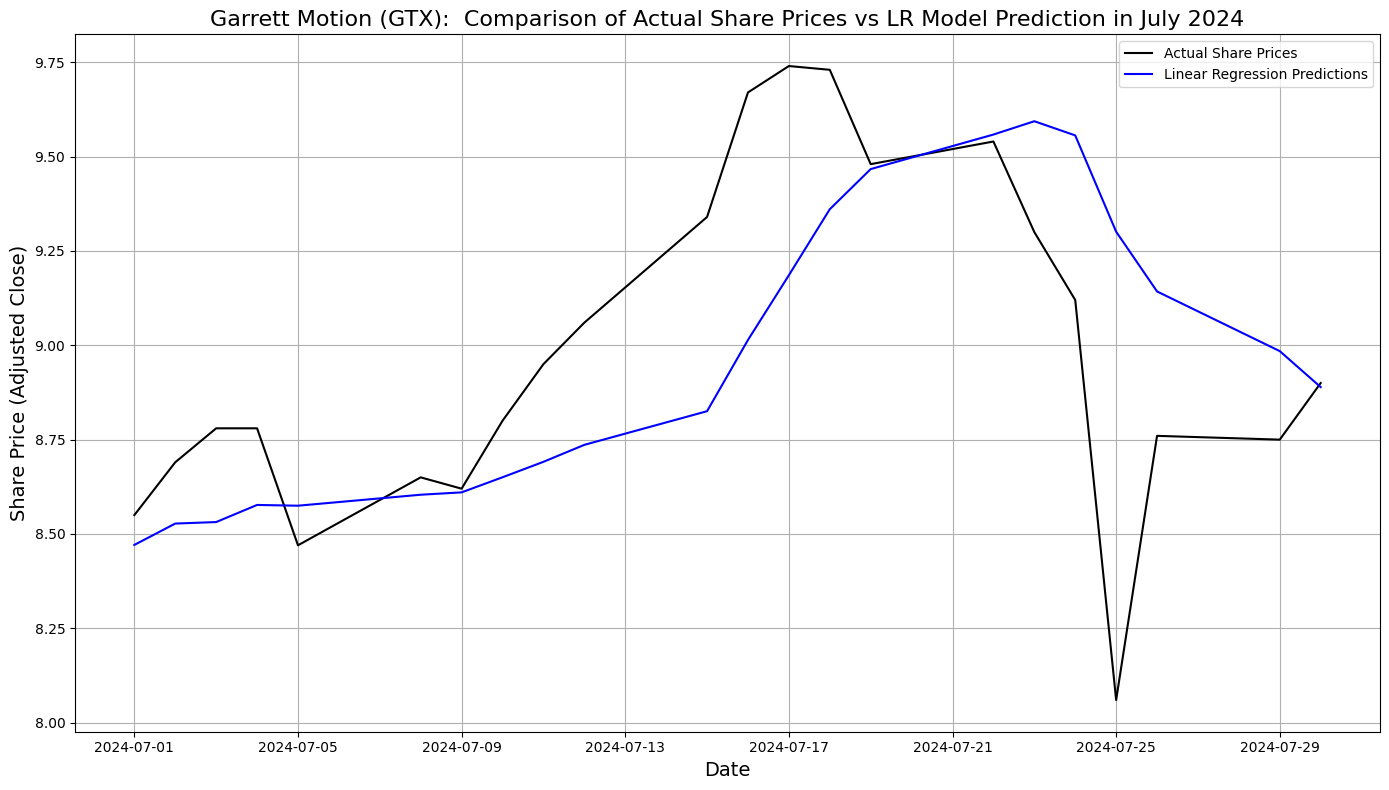

In [17]:
plt.figure(figsize=(14, 8))
plt.plot(july_2024_df.index, july_2024_df['Actual'], label="Actual Share Prices", color="black") # Plot actual share prices in test data
plt.plot(july_2024_df.index, july_2024_df['LR Prediction'], label="Linear Regression Predictions", color="blue") # Plot Linear Regression predictions

plt.title("Garrett Motion (GTX):  Comparison of Actual Share Prices vs LR Model Prediction in July 2024", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Share Price (Adjusted Close)", fontsize=14)
plt.legend()

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

By looking at a single month, we observe that the linear regression model is a less volatile representation of the actual share price.  In most cases, when a sharp move up or down occurs in the actual share price, the model predicts a less dramatic move due to the smoothing effect of the moving averages.  In some cases, this causes large errors, such as on July 25, when the actual closing price was \$8.06 but the predicted value was \$9.30.  Not surprisingly, there was company-specific news on this day - GTX reported financial results that disappointed investors.

Prior to the disappointing financial report, GTX shares had already started declining.  On July 22, shares closed at \$9.54, followed by \$9.30 on the 23rd and \$9.12 on the 24th.  So the short-term trend was negative, which benefited the model in predicting the close on the 25th.  Yet, the predicted value was still very far from the actual price.  Had the share price of GTX increased during the two days prior to the earnings report, the model would have surely missed by even more because the short-term trend would have been more positive.

Conversely, if the July 25 earnings report had greatly exceeded investor expectations, the share price likely would have spiked and the model probably would have underestimated the price move in this situation as well.

Reducing the number of days used in the moving average could help capture more volatility but our model is not constructed to predict the company's financial results, so it will be difficult to forecast some of these dramatic price moves using any variation of our current linear regression model.

**Implications of Model Performance for Real-World Decision-Making in Finance**

---



If we were planning to deploy an investing or trading system based on the above models, more rigorous testing and evaluation would be required.  Although the error metrics for the linear regression model appear small, these errors could compound into very large losses very quickly.

If we were designing the model for a specific strategy, factors such as risk tolerance and holding period would also have to be considered.  For example, if we are a long-term investors, day to day predictions may be of little value.  But if we're short-term traders who transact in a single stock many times per days, predicting closing prices may be of less interest than predicting prices over the next minute or hour.

Despite how well a model appears to perform during testing, market dynamics can change very quickly.  The factors previously driving a stock performance may become insignificant as investors begin to proritize other factors.  This could be something company-specific, like an accounting irregularity or something with wide-ranging economic implications, like the onset of a global pandemic.  Regardless of the current economic environment and the financial asset being traded, constant evaluation and adjustments will be necessary.


## LSTM Model Implementation

**Develop an LSTM model on the dataset with proper configuration and parameter tuning:**

In [18]:
! pip install tensorflow

In [19]:
# Import necessary libraries

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os

import random

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [20]:
import os

# Enable deterministic operations in TensorFlow
os.environ['TF_DETERMINISTIC_OPS'] = '1'


In [21]:
# Use actual adjusted close prices for training
actual_prices_LSTM = stock_data['Adj Close']

In [22]:
# Normalize prices to the range [0, 1] because LSTMs perform better when data is scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(actual_prices_LSTM)

In [23]:
# Create sequences for LSTM.  For each price prediction, the model will look at the previous n_steps days
def create_sequences_with_dates(data, dates, n_steps):
    X, y, valid_dates = [], [], []
    for i in range(n_steps, len(data)):  # n_steps is the starting index of the loop.  range will generate a sequence of integers starting from n_steps and stopping before len(data) which is the length of the data
        X.append(data[i-n_steps:i, 0])  # Creates a window of n_steps rows, ending just before the current index i
        y.append(data[i, 0])  # Target value (next day)
        valid_dates.append(dates[i])
    return np.array(X), np.array(y), valid_dates

# Prepare data for LSTM
dates = stock_data.index.values
n_steps = 30
X, y, valid_dates = create_sequences_with_dates(scaled_prices, dates, n_steps)

# Reshape X to be [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))


In [24]:
X.shape

(734, 30, 1)

In [25]:
y.shape

(734,)

In [26]:
# Split data into training and testing

train_indices = [i for i, date in enumerate(valid_dates) if date < pd.to_datetime(split_date)]
test_indices = [i for i, date in enumerate(valid_dates) if date >= pd.to_datetime(split_date)]

X_train_LSTM, y_train_LSTM = X[train_indices], y[train_indices]
X_test_LSTM, y_test_LSTM = X[test_indices], y[test_indices]

# Extract test dates from valid_dates using test_indices (for plotting)
test_dates = [valid_dates[i] for i in test_indices]


In [27]:
# Print shapes for verification
print(f"X_train_LSTM shape: {X_train_LSTM.shape}, y_train shape: {y_train_LSTM.shape}")
print(f"X_test_LSTM shape: {X_test_LSTM.shape}, y_test shape: {y_test_LSTM.shape}")

X_train_LSTM shape: (580, 30, 1), y_train shape: (580,)
X_test_LSTM shape: (154, 30, 1), y_test shape: (154,)


In [28]:
# Create LSTM Model and define hyperparameters

model_LSTM = Sequential([
    LSTM(50, return_sequences=True, input_shape=(n_steps, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name="Adam")  #specify kernel parameters for reproducibility

# Compile the model
model_LSTM.compile(optimizer=optimizer, loss='mean_squared_error')

# Display the model summary
model_LSTM.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model_LSTM.fit(X_train_LSTM, y_train_LSTM, epochs=50, batch_size=32, validation_data=(X_test_LSTM, y_test_LSTM), shuffle=False, verbose=1)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - loss: 0.0518 - val_loss: 0.0067
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0247 - val_loss: 0.0059
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0183 - val_loss: 0.0060
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0133 - val_loss: 0.0063
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0098 - val_loss: 0.0071
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0105 - val_loss: 0.0060
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0097 - val_loss: 0.0065
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0094 - val_loss: 0.0102
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0127 - val_loss: 0.0059
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0090 - val_loss: 0.0052
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0084 - val_loss: 0.0064
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss:

## LTSM Model Prediction and Visualization
**Use the LSTM model for predictions:**

In [30]:
# Predict on the test set
y_pred_LSTM = model_LSTM.predict(X_test_LSTM)

# Inverse transform the predictions and actual values to original scale
y_pred_LSTM_rescaled = scaler.inverse_transform(y_pred_LSTM.reshape(-1, 1))
y_test_LSTM_rescaled = scaler.inverse_transform(y_test_LSTM.reshape(-1, 1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


**Visualize the predicted values:**

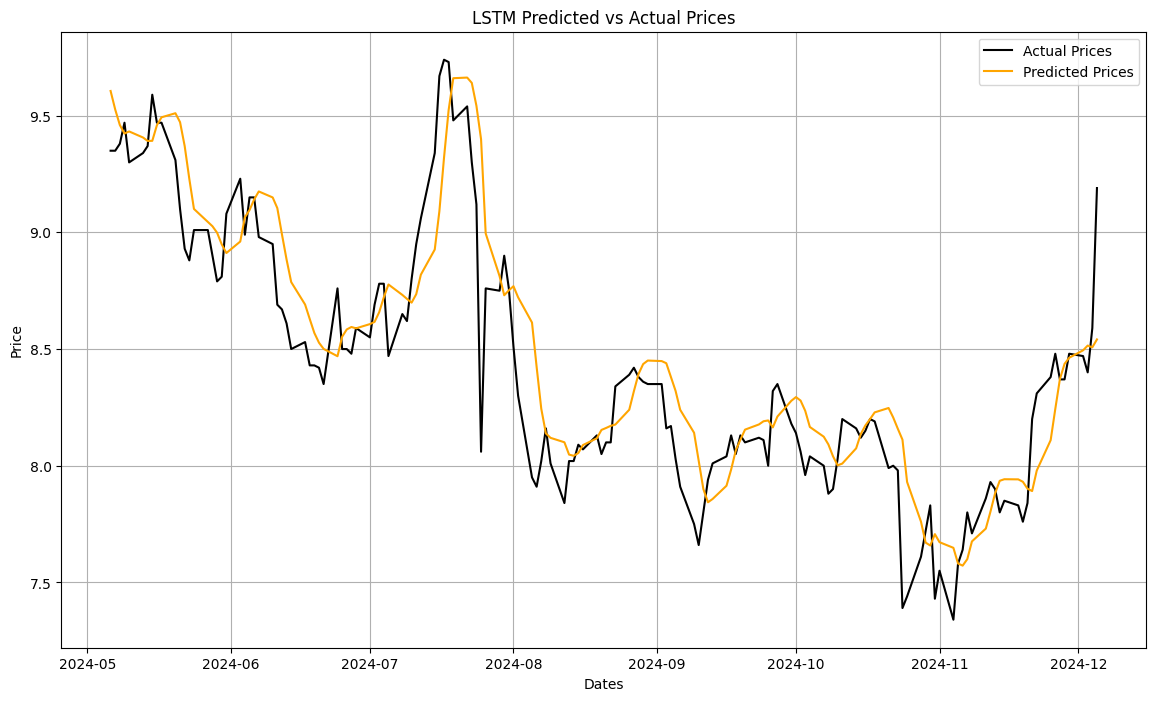

In [31]:
plt.figure(figsize=(14, 8))
plt.plot(test_dates, y_test_LSTM_rescaled, label='Actual Prices', color='black')
plt.plot(test_dates, y_pred_LSTM_rescaled, label='Predicted Prices', color='orange')
plt.title('LSTM Predicted vs Actual Prices')
plt.xlabel('Dates')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

**Evaluate the LSTM model using appropriate metrics:**

In [32]:
# Calculate performance metrics for LSTM model
mae_lstm = mean_absolute_error(y_test_LSTM_rescaled, y_pred_LSTM_rescaled)
mse_lstm = mean_squared_error(y_test_LSTM_rescaled, y_pred_LSTM_rescaled)
rmse_lstm = np.sqrt(mse_lstm)

# Print performance metrics for LSTM model
print("------LSTM Model Performance Metrics------")
print(f"Mean Absolute Error (MAE): {mae_lstm:.2f}")
print(f"Mean Squared Error (MSE): {mse_lstm:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lstm:.2f}")

# Print performance metrics for Linear Regression model (copied from above)
print("\n------Linear Regression Model Performance Metrics------")
print(f"Mean Absolute Error (MAE): {mae_linear_reg:.2f}")
print(f"Mean Squared Error (MSE): {mse_linear_reg:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_linear_reg:.2f}")

------LSTM Model Performance Metrics------
Mean Absolute Error (MAE): 0.18
Mean Squared Error (MSE): 0.06
Root Mean Squared Error (RMSE): 0.24

------Linear Regression Model Performance Metrics------
Mean Absolute Error (MAE): 0.17
Mean Squared Error (MSE): 0.05
Root Mean Squared Error (RMSE): 0.23


**Compare models and discuss the findings:**

The LSTM model's performance is very close to our linear regression model from earlier (the Holt-Winters model performed far worse than both, so it won't be discussed here).

The MAE for the LSTM model was 0.18 vs 0.17 for the linear regression model.  LSTM produced a slightly higher MSE (0.06 vs 0.05) and slightly higher RMSE (0.24 vs 0.23).

We could expect similar performance metrics across these two models because both are using a window (or range) of adjusted closing prices to predict a future value.  They are computationally different approaches but both models are using only one value for each trading day.  The moving averages used as inputs in the linear regression model are constructed using the same adjusted closing prices that the LSTM model is using as a direct input.

Let's view all three (LSTM, Linear Regression and Actual) on the same plot:

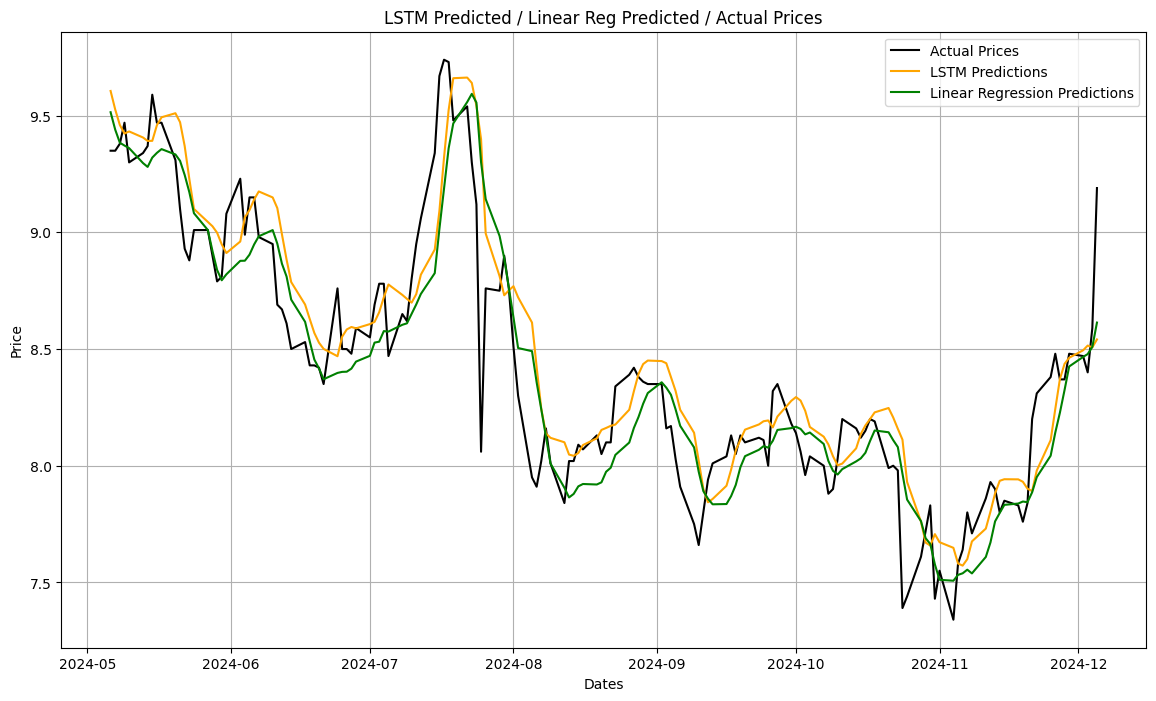

In [33]:
plt.figure(figsize=(14, 8))
plt.plot(test_dates, y_test_LSTM_rescaled, label='Actual Prices', color='black')
plt.plot(test_dates, y_pred_LSTM_rescaled, label='LSTM Predictions', color='orange')
plt.plot(test_dates, y_pred_linear_reg, label="Linear Regression Predictions", color="green") # Plot Linear Regression predictions

plt.title('LSTM Predicted / Linear Reg Predicted / Actual Prices')
plt.xlabel('Dates')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

Based on the above plot, it appears the actual prices still exhibit more volatility than either of the predicted values.  Let's compute the standard deviation of each:

In [34]:
std_pred_lstm = np.std(y_pred_LSTM_rescaled)
std_pred_linear = np.std(y_pred_linear_reg)
std_actual = np.std(y_test_LSTM_rescaled)

# Print the results
print(f"Standard Deviation of LSTM Predictions: {std_pred_lstm:.4f}")
print(f"Standard Deviation of Linear Regression Predictions: {std_pred_linear:.4f}")
print(f"Standard Deviation of Actual Prices: {std_actual:.4f}")

Standard Deviation of LSTM Predictions: 0.5430
Standard Deviation of Linear Regression Predictions: 0.5408
Standard Deviation of Actual Prices: 0.5563


All three sets of prices exhibit similar levels of volatility but the actual prices are slightly more volatile than either set of predictions, which was observed in the above plot.  We only used standard deviation so results may vary if different volatility metrics were employed.

Let's see if we can improve the performance of the LSTM model through hyperparameter tuning:

In [35]:
! pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.7 MB/s eta 0:00:00


In [37]:
# Import required libraries
import tensorflow as tf
import numpy as np
import random
import os
from keras_tuner.tuners import BayesianOptimization


# Set seeds for reproducibility
seed = 42
np.random.seed(seed)             # NumPy seed
tf.random.set_seed(seed)         # TensorFlow seed
random.seed(seed)                # Python random seed

# Ensure deterministic operations for TensorFlow (useful for GPUs)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Automate Hyperparameter Tuning with Keras Tuner
from keras_tuner.tuners import RandomSearch

def build_better_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=256, step=32),  # Tunable hidden state size
        return_sequences=True,
        input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))  # Tunable dropout
    model.add(LSTM(hp.Int('units', min_value=32, max_value=256, step=32), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])  # Tunable learning rate
        ),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

# Initialize the tuner
tuner = BayesianOptimization(
    build_better_model,
    objective='val_loss',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_tuning'
)

# Perform hyperparameter search
tuner.search(
    X_train_LSTM,
    y_train_LSTM,
    epochs=50,
    validation_data=(X_test_LSTM, y_test_LSTM),
    batch_size=32,
    shuffle=False  # Disable shuffling for reproducibility
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")


Trial 10 Complete [00h 04m 57s]
val_loss: 0.0023148152977228165

Best val_loss So Far: 0.002057222882285714
Total elapsed time: 00h 27m 12s
Best hyperparameters: {'units': 160, 'dropout_rate': 0.1, 'learning_rate': 0.001}


Above, the best hyperparameter values (units, dropout_rate, learning_rate) are provided.

Now, let's retrain the model with these hyperparameters to optimize performance.

In [38]:
# Build the model with the best hyperparameters
best_LSTM_model = tuner.hypermodel.build(best_hps)

# Train the model
history = best_LSTM_model.fit(X_train_LSTM, y_train_LSTM, epochs=50, validation_data=(X_test_LSTM, y_test_LSTM), batch_size=32)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - loss: 0.0878 - mae: 0.2169 - val_loss: 0.0060 - val_mae: 0.0590
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0090 - mae: 0.0734 - val_loss: 0.0054 - val_mae: 0.0564
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0068 - mae: 0.0628 - val_loss: 0.0052 - val_mae: 0.0559
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.0064 - mae: 0.0600 - val_loss: 0.0051 - val_mae: 0.0558
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 0.0061 - mae: 0.0589 - val_loss: 0.0052 - val_mae: 0.0560
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 0.0059 - mae: 0.0580 - val_loss: 0.0052 - val_mae: 0.0564
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0060 - mae: 0.0582 - val_loss: 0.0044 - val_mae: 0.0511
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0052 - mae: 0.0541 - val_loss: 0.0046 - val_mae: 0.0522
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - lo

In [39]:
# Make predictions on the test data
y_pred_v2 = best_LSTM_model.predict(X_test_LSTM)

# Rescale the predictions and actual values (if normalized or scaled during preprocessing)
y_pred_v2_rescaled = scaler.inverse_transform(y_pred_v2)
y_test_v2_rescaled = scaler.inverse_transform(y_test_LSTM.reshape(-1, 1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step


In [40]:
# Calculate performance metrics for optimized LSTM model
mae_lstm_v2 = mean_absolute_error(y_test_LSTM_rescaled, y_pred_v2_rescaled)
mse_lstm_v2 = mean_squared_error(y_test_LSTM_rescaled, y_pred_v2_rescaled)
rmse_lstm_v2 = np.sqrt(mse_lstm_v2)

# Print performance metrics for optimized LSTM model
print("------Optimized LSTM Model Performance Metrics------")
print(f"Mean Absolute Error (MAE): {mae_lstm_v2:.2f}")
print(f"Mean Squared Error (MSE): {mse_lstm_v2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lstm_v2:.2f}")

# Print performance metrics for LSTM model (copied from above)
print("\n------LSTM Model Performance Metrics------")
print(f"Mean Absolute Error (MAE): {mae_lstm:.2f}")
print(f"Mean Squared Error (MSE): {mse_lstm:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lstm:.2f}")

# Print performance metrics for Linear Regression model (copied from above)
print("\n------Linear Regression Model Performance Metrics------")
print(f"Mean Absolute Error (MAE): {mae_linear_reg:.2f}")
print(f"Mean Squared Error (MSE): {mse_linear_reg:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_linear_reg:.2f}")

------Optimized LSTM Model Performance Metrics------
Mean Absolute Error (MAE): 0.14
Mean Squared Error (MSE): 0.04
Root Mean Squared Error (RMSE): 0.20

------LSTM Model Performance Metrics------
Mean Absolute Error (MAE): 0.18
Mean Squared Error (MSE): 0.06
Root Mean Squared Error (RMSE): 0.24

------Linear Regression Model Performance Metrics------
Mean Absolute Error (MAE): 0.17
Mean Squared Error (MSE): 0.05
Root Mean Squared Error (RMSE): 0.23


By optimizing units, dropout_rate and learning_rate, our updated LSTM model is outperforming both the original LSTM and the linear regression model created earlier.  The optimized LSTM model outperforms the other models across all three performance metrics.  Certainly, more testing and evaluation would be required before implementing a trading strategy around this optimized LSTM model.